## 1. Main

* Feature analysis
* Feature engineering
* Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data

In [2]:
# Load

train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
IDtest = test['PassengerId']


### 2.2 Outlier detection

In [3]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
    
    
    

In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

* 분포 값(IQR)의 첫 번째 사분위수와 세 번째 사분위수 사이에 포함된 사분위간 범위를 정의하는 outlier를 탐지하기 위해 Tukey 방법(Tukey JW., 1977)을 사용.
* numerical value features 사용(Age, SibSp, Sarch and Fare)

In [5]:
# Show outlier row
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


**10 outliers**
* passenger 28, 89, 342 have an high Ticket Fare
* othes have very high in SibSP.



In [6]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

**reset_index**

인덱스 초기화하고 재배열해주는 함수, 데이터 전처리 하다보면 인덱스 뒤죽박죽됨.

* drop = True 기존 인덱스 버리고 재배열
* inplace = True 

### 2.3 joining train and test set

In [7]:
# concatenating dataframes
# 데이터프레임 합치기

train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 2.4 check for null and missing values

In [8]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

결측치에서 Age와 Cabin이 중요한 피처임을 확인

In [9]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
## Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3.Feature analysis


### 3.1 Numerical values

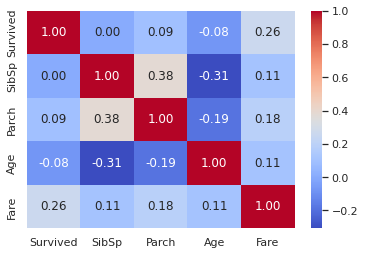

In [13]:
# Correlation.matirx between numerical values (SibSp Parch Age and Fare values) and Survived

g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

**SibSP**

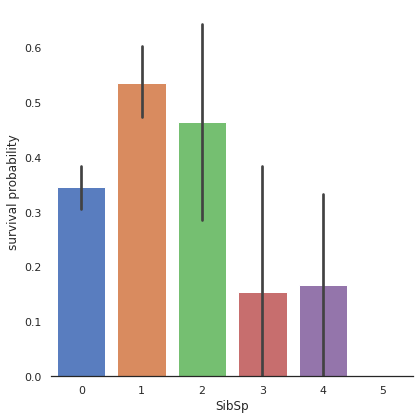

In [14]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind='bar', size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

passenges having a lot of siblings/spouses have less chance to survive.

Single passengers(0 Sib) or with two other persons(1 of 2) have more chance to survive.

**Parch**

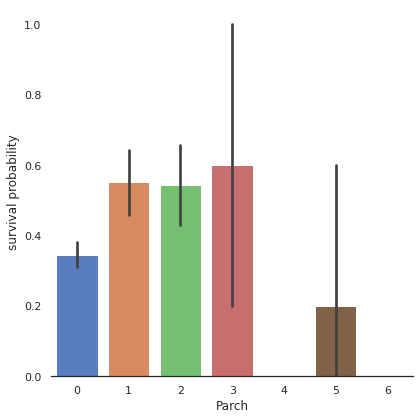

In [15]:
# Explore Parch feature vs Survived
g = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).


Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children

**Age**

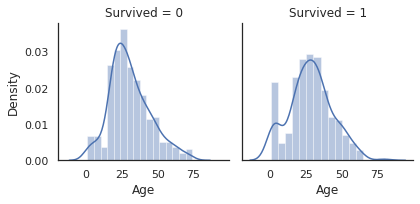

In [16]:
# Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

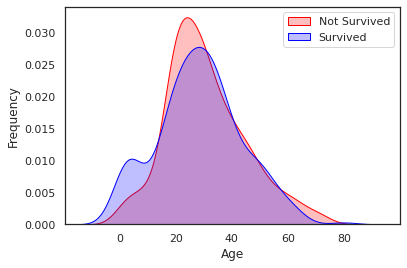

In [17]:
# Age distibution
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax= g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

can see a peak between 0 and 5

**Fare**

In [18]:
dataset["Fare"].isnull().sum()

1

In [19]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

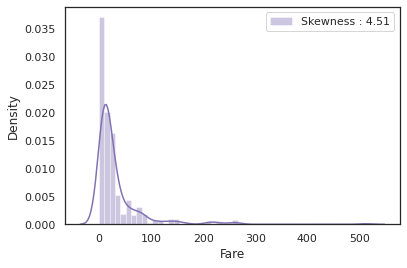

In [20]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

분포가 비대칭적임. This can lead to overweigth very high values in the model, even if it is scaled.

better to transform it with the log function to reduce tis skew.

In [21]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

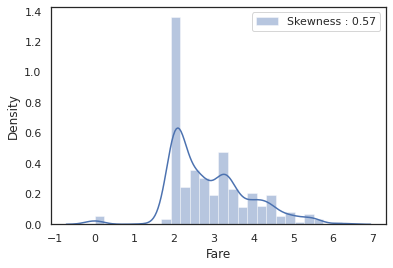

In [22]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [23]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


**Pclass**

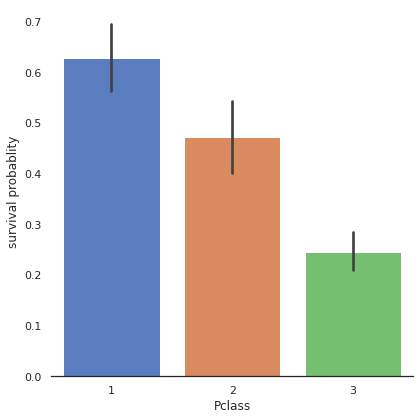

In [24]:
# Pclass vs Survived
g = sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probablity")

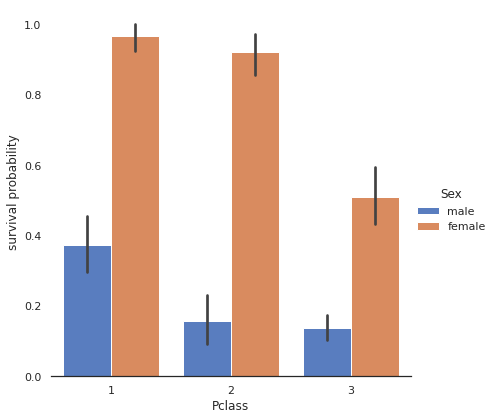

In [25]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train, size=6, kind='bar', palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

**Embarked**

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
# Fill nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

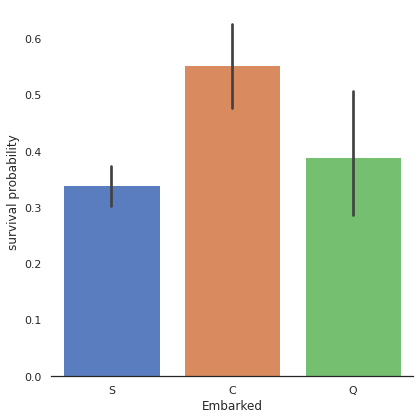

In [28]:
# Explore Embarked vs Survived
g = sns.factorplot(x="Embarked", y="Survived", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

passenger coming form Cherbourg(C) have more chance to survie than Queenstown(Q) and Southampton(S).

hypothesis: proportion of first class passengers is higher for those who came from C > Q > S

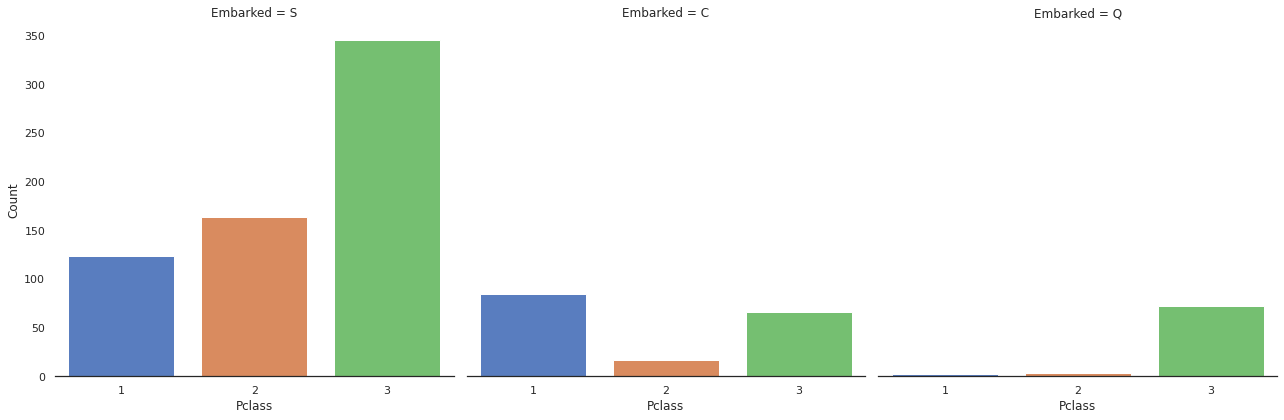

In [29]:
# Explore Pclass vs Embarked
g = sns.factorplot("Pclass", col="Embarked", data=train, size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

third class is the most frequent for passenger coming from Southhampton(S) and Q. C passengers are mostly in first class which have the highest survival rate.

## 4. Filling missing Values

### 4.1 Age

* Age column contains 256 missing values
* 생존 가능성 더 높은 집단(어린이)이 있으니 age feature에 결측값 넣어서 사용하는 것이 바람직
* 문제 해결을 위해 age와 상관관계가 있는 다른 feature들 확인




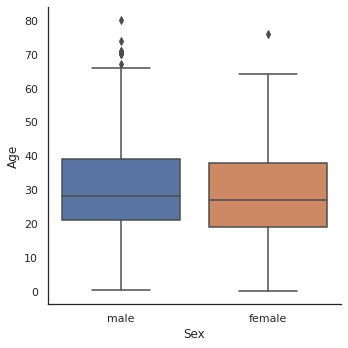

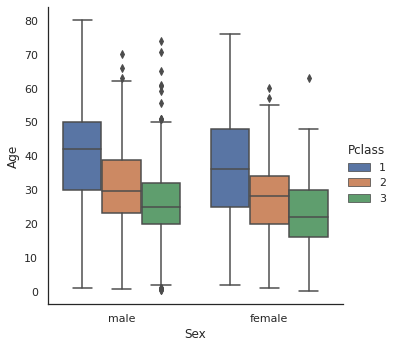

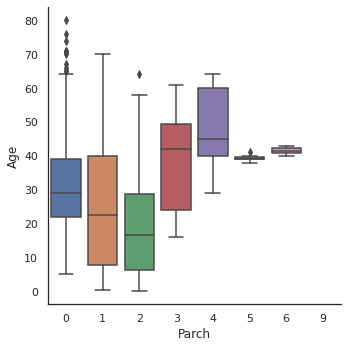

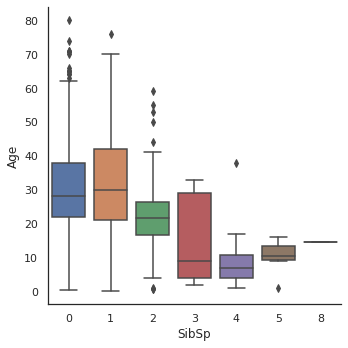

In [30]:
# Explore Age vs Sex, Parch, Pclass and SibSP
g = sns.factorplot(y="Age", x="Sex", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="Parch", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="SibSp", data=dataset, kind="box")

age는 남성 여성 비슷

But 일등석 > 이등석 > 삼등석

승객이 부모, 자녀를 더 많이 가질수록 나이가 더 많고 형제/배우자를 더 많이 가질수록 나이가 더 젊음..

In [31]:
# convert sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})

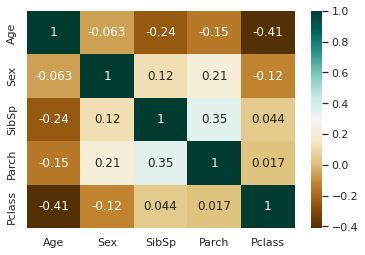

In [32]:
g = sns.heatmap(dataset[["Age", "Sex", "SibSp","Parch","Pclass"]].corr(),cmap="BrBG", annot=True)

age is negatively correalted with Pclass,Parch and SibSp.

now, fill age with the median age of similar rows accroding to Pclass, Parch and SibSp!

In [33]:
# Filling missing value of Age
# Fill age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

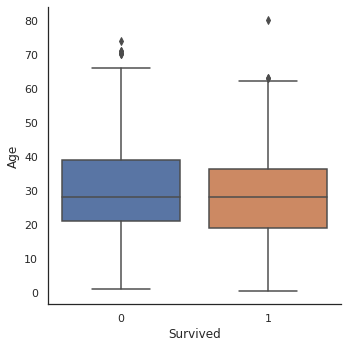

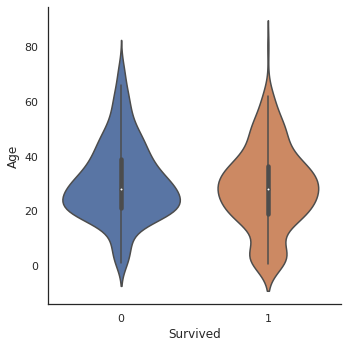

In [34]:
g = sns.factorplot(x="Survived", y = "Age", data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age", data = train, kind="violin")

* no difrrerecne between median value of age in survival and not survived subpopulation.
* But in violin plot of survived passengers, young passengers have higher survival rate.

## 5. Feature engineering


### 5.1 Name/Title

In [35]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [36]:
# Get Title from Name

dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

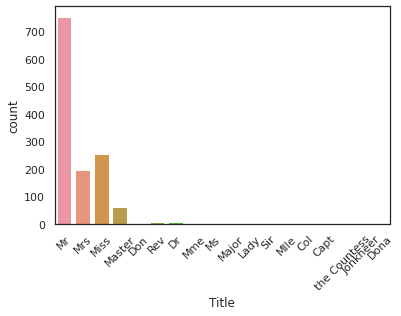

In [37]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [38]:
# Convert to categorical values Title
# categorical data를 0/1/2 등으로 encoding 해주는 map 함수
# very rare한 애들은 Rare로 replace 해주고 3으로 encoding

dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})

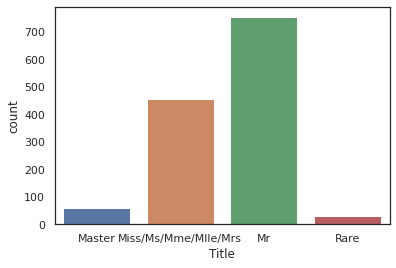

In [39]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

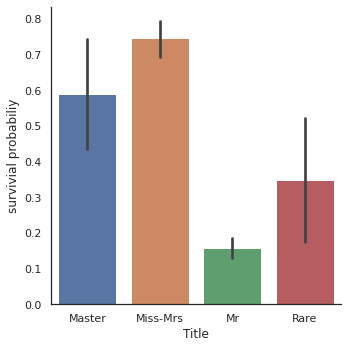

In [40]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr","Rare"])
g = g.set_ylabels("survivial probabiliy")

In [41]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### 5.2 Family size

In [42]:
# create a family size descriptor form sibsp and parch
# 패밀리사이즈 피처 만들기! 형제자매 + 부모님

dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

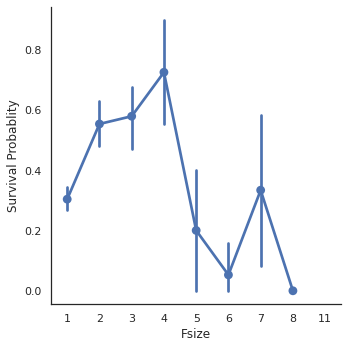

In [43]:
g = sns.factorplot(x="Fsize", y="Survived", data = dataset)
g = g.set_ylabels("Survival Probablity")

In [44]:
# create new feature of family size
# 1,2, 3/4, 5이상으로 4가지로 나눔

dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <=4  else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

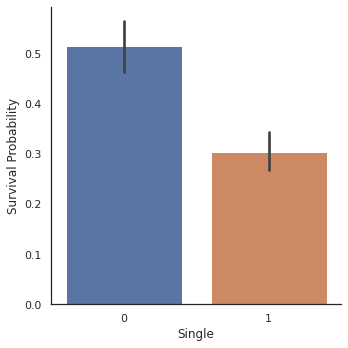

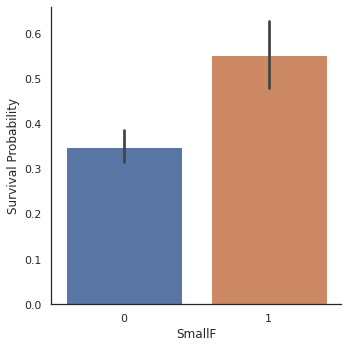

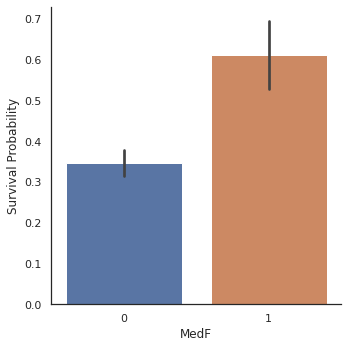

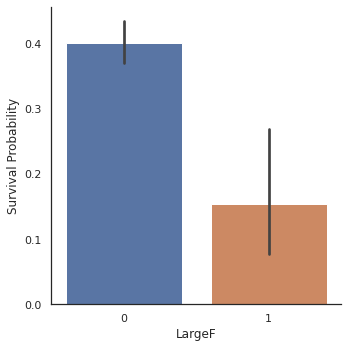

In [45]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [46]:
# Convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [47]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


22 features!

### 5.3 Cabin

In [48]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 missing values.

cabin이 없는 승객은 missing value로 뜨는 것 같음. 결측치를 x로 넣어주기

In [51]:
# replace the cabin number by the type of cabin 'x' if not

dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

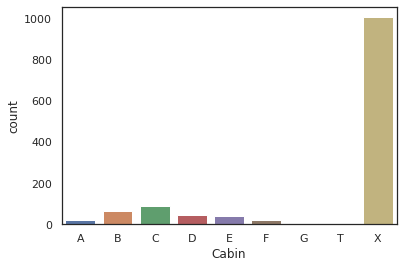

In [52]:
g = sns.countplot(dataset["Cabin"], order=['A','B','C','D','E','F','G','T','X'])

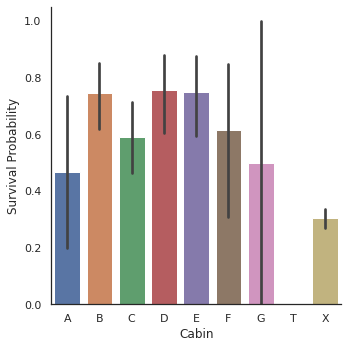

In [53]:
g = sns.factorplot(y="Survived", x="Cabin", data=dataset, kind="bar", order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

cabin을 가진 승객이 적어서 생존률 표준편차가 넘 크고 등급별 구분이 쉽지 않음

그래도 객실이 없는 승객보다는 생존률이 높은 것을 확인 가능함.

In [54]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [55]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [56]:
# Treat ticket by extracting the ticket prefix. When there is no prefix it returns x.

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

## 6. Modeling

In [57]:
# Separate train and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis =1, inplace=True)

In [58]:
# Separate train feautres and label

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis =1)

### 6.1 Simple modeling

#### 6.1.1 Cross validate models

In [59]:
# Kfold

kfold = StratifiedKFold(n_splits=10)

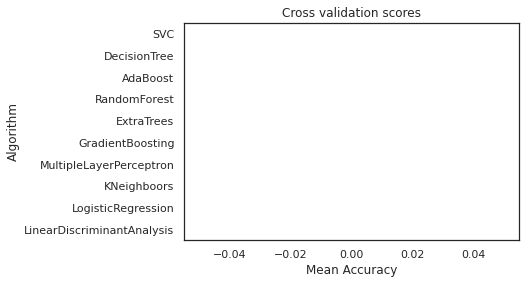

In [60]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

